### Get area of interest (AOI) from geopandas Dataframe and download images with sentinelsat API

Docs: https://sentinelsat.readthedocs.io/en/stable/api_overview.html

GitHub: https://github.com/sentinelsat/sentinelsat

1. Open geopandas dataframe
2. Select one polygon from Germany
   - Data from http://www.diva-gis.org/gdata
   - Select germany and Administrative areas
   - DEU_adm1.shp contains the borders as polygons from each state
   - DEU_adm2.shp contains the borders as polygons from each district
3. Create API call with sentinelsat
   - Check if crs is the same as in the geopandas dataframe
   - Check if data/product is online (https://sentinelsat.readthedocs.io/en/stable/api_overview.html#lta-products)
   - (Future ToDo:) Create handling of LTA-products
4. Unpack retrieved data
5. extract only RGB and NIR bands as well as important meta-data 

In [2]:
import rasterio
from rasterio import plot
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import numpy as np
import os
import geopandas as gpd
from shapely import geometry
from shapely.geometry import Polygon
from geopandas import GeoSeries, GeoDataFrame
from pyproj import Proj, transform
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt, make_path_filter
from datetime import date
from zipfile import ZipFile
import shutil

### 1. Open geopandas dataframe

In [3]:
trn_polygons_path = r'C:\Users\Fabian\OneDrive - Universität Würzburg\Uni Würzburg\Master\Masterthesis\Code\Einarbeitung\trn_polygons.geojson'
trn_polygons = gpd.read_file(trn_polygons_path)

### 2. Select one polygon from Germany (close to wuerzburg)

In [4]:
germany_borders_path = r'C:\Users\Fabian\Documents\Masterarbeit_Daten\DEU_adm\DEU_adm3.shp'
germany_borders = gpd.read_file(germany_borders_path)

In [5]:
germany_borders.head()

ID_0  ISO   NAME_0  ID_1             NAME_1  ID_2    NAME_2  ID_3  \
0    86  DEU  Germany     1  Baden-Württemberg     1  Freiburg     1   
1    86  DEU  Germany     1  Baden-Württemberg     1  Freiburg     2   
2    86  DEU  Germany     1  Baden-Württemberg     1  Freiburg     3   
3    86  DEU  Germany     1  Baden-Württemberg     1  Freiburg     4   
4    86  DEU  Germany     1  Baden-Württemberg     1  Freiburg     5   

                     NAME_3      TYPE_3       ENGTYPE_3 NL_NAME_3  VARNAME_3  \
0  Breisgau-Hochschwarzwald  Landkreise  Rural district       NaN        NaN   
1               Emmendingen  Landkreise  Rural district       NaN        NaN   
2                  Freiburg         NaN             NaN       NaN        NaN   
3                  Konstanz  Landkreise  Rural district       NaN  Constance   
4  Lörrach \r\nLörrach \r\n  Landkreise  Rural district       NaN    Lörrach   

                                            geometry  
0  POLYGON ((7.55564 47.87053, 7.55578 47.87120, ...  
1  POLYGON ((7.57809 48.11961, 7.57786 48.12139, ...  
2  POLYGON ((7.82635 48.07057, 7.83203 48.06703, ...  
3  MULTIPOLYGON (((8.85385 47.68377, 8.85416 47.6...  
4  POLYGON ((7.63238 47.56242, 7.63560 47.56353, ...

In [6]:
# select the boundaries of the district of Wuerzburg
wuerzburg_borders = germany_borders[germany_borders.NAME_3 =='Würzburg']

In [7]:
wuerzburg_borders

ID_0  ISO   NAME_0  ID_1  NAME_1  ID_2        NAME_2  ID_3    NAME_3  \
139    86  DEU  Germany     2  Bayern    11  Unterfranken   140  Würzburg   

         TYPE_3       ENGTYPE_3 NL_NAME_3 VARNAME_3  \
139  Landkreise  Rural district       NaN       NaN   

                                              geometry  
139  POLYGON ((10.11396 49.61599, 10.10825 49.61595...

In [8]:
# filter training polygons which lies within the borders of district of Wuerzburg
polygons_wuerzburg= gpd.clip(trn_polygons, wuerzburg_borders)

In [9]:
# select one polygon (=solar plant) to check if it matches on the satellite image and to use as footprint
polygons_giebelstadt = polygons_wuerzburg[polygons_wuerzburg.name == 'Solarpark Giebelstadt'].reset_index()

In [9]:
polygons_giebelstadt.geometry

0    POLYGON ((9.95160 49.64825, 9.95157 49.64835, ...
Name: geometry, dtype: geometry

In [13]:
# check for crs
polygons_giebelstadt.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

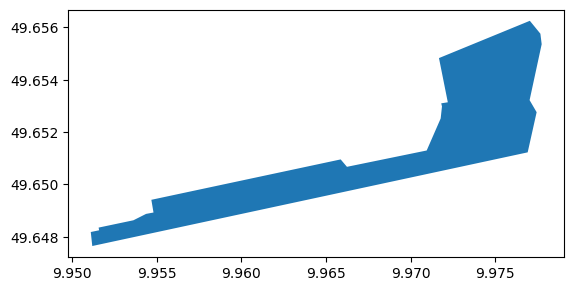

In [14]:
polygons_giebelstadt.plot()

### 3. Create API call with sentinelsat

In [2]:
# put credentials in file
api = SentinelAPI('taraman', 'y6HG%!6cF!86y$tK3', 'https://apihub.copernicus.eu/apihub')

In [15]:
# remember to reset_index of the subset from the df
footprint = polygons_giebelstadt.loc[0, 'geometry'].wkt

In [16]:
# query for image which lies within the footprint of the selected polygon (=solar plant)
products = api.query(footprint,
                     date=('20220601', date(2023, 2, 11)),
                     platformname='Sentinel-2',
                     cloudcoverpercentage=(0, 30),
                     limit=1) #area_relation='IsWithin',#processinglevel="Level-2A"

In [17]:
# response from api query, as OrderedDict
products

OrderedDict([('7520a2cd-f72d-402c-85a1-37a37ead54fa',
              {'title': 'S2A_MSIL2A_20230208T103211_N0509_R108_T32UNA_20230208T164302',
               'link': "https://apihub.copernicus.eu/apihub/odata/v1/Products('7520a2cd-f72d-402c-85a1-37a37ead54fa')/$value",
               'link_alternative': "https://apihub.copernicus.eu/apihub/odata/v1/Products('7520a2cd-f72d-402c-85a1-37a37ead54fa')/",
               'link_icon': "https://apihub.copernicus.eu/apihub/odata/v1/Products('7520a2cd-f72d-402c-85a1-37a37ead54fa')/Products('Quicklook')/$value",
               'summary': 'Date: 2023-02-08T10:32:11.024Z, Instrument: MSI, Satellite: Sentinel-2, Size: 1.12 GB',
               'ondemand': 'false',
               'generationdate': datetime.datetime(2023, 2, 8, 16, 43, 2),
               'beginposition': datetime.datetime(2023, 2, 8, 10, 32, 11, 24000),
               'endposition': datetime.datetime(2023, 2, 8, 10, 32, 11, 24000),
               'ingestiondate': datetime.datetime(2023, 

In [18]:
# it is possible to convert the OrderedDict to geopandas Dataframe to work on this
api.to_geodataframe(products)

title  \
7520a2cd-f72d-402c-85a1-37a37ead54fa  S2A_MSIL2A_20230208T103211_N0509_R108_T32UNA_2...   

                                                                                   link  \
7520a2cd-f72d-402c-85a1-37a37ead54fa  https://apihub.copernicus.eu/apihub/odata/v1/P...   

                                                                       link_alternative  \
7520a2cd-f72d-402c-85a1-37a37ead54fa  https://apihub.copernicus.eu/apihub/odata/v1/P...   

                                                                              link_icon  \
7520a2cd-f72d-402c-85a1-37a37ead54fa  https://apihub.copernicus.eu/apihub/odata/v1/P...   

                                                                                summary  \
7520a2cd-f72d-402c-85a1-37a37ead54fa  Date: 2023-02-08T10:32:11.024Z, Instrument: MS...   

                                     ondemand      generationdate  \
7520a2cd-f72d-402c-85a1-37a37ead54fa    false 2023-02-08 16:43:02   

                                               beginposition  \
7520a2cd-f72d-402c-85a1-37a37ead54fa 2023-02-08 10:32:11.024   

                                                 endposition  \
7520a2cd-f72d-402c-85a1-37a37ead54fa 2023-02-08 10:32:11.024   

                                               ingestiondate  ...  \
7520a2cd-f72d-402c-85a1-37a37ead54fa 2023-02-08 18:22:55.101  ...   

                                      producttype  platformidentifier  \
7520a2cd-f72d-402c-85a1-37a37ead54fa      S2MSI2A           2015-028A   

                                      orbitdirection  \
7520a2cd-f72d-402c-85a1-37a37ead54fa      DESCENDING   

                                      platformserialidentifier  \
7520a2cd-f72d-402c-85a1-37a37ead54fa               Sentinel-2A   

                                      processinglevel  \
7520a2cd-f72d-402c-85a1-37a37ead54fa         Level-2A   

                                                                    datastripidentifier  \
7520a2cd-f72d-402c-85a1-37a37ead54fa  S2A_OPER_MSI_L2A_DS_2APS_20230208T164302_S2023...   

                                                                      granuleidentifier  \
7520a2cd-f72d-402c-85a1-37a37ead54fa  S2A_OPER_MSI_L2A_TL_2APS_20230208T164302_A0398...   

                                                                             identifier  \
7520a2cd-f72d-402c-85a1-37a37ead54fa  S2A_MSIL2A_20230208T103211_N0509_R108_T32UNA_2...   

                                                                      uuid  \
7520a2cd-f72d-402c-85a1-37a37ead54fa  7520a2cd-f72d-402c-85a1-37a37ead54fa   

                                                                               geometry  
7520a2cd-f72d-402c-85a1-37a37ead54fa  MULTIPOLYGON (((10.47236 49.55510, 10.50102 49...  

[1 rows x 41 columns]

In [19]:
# get uuid from product (as OrderedDict) to download it
uuid = list(products.keys())[0]


In [20]:
# get identifier which is used as the folder name to get the images from it
identifier = products[uuid]['identifier']
identifier

'S2A_MSIL2A_20230208T103211_N0509_R108_T32UNA_20230208T164302'

In [31]:
footprint = products[uuid]['footprint']
footprint

'MULTIPOLYGON (((10.472358732978224 49.55509844460375, 10.501018029382427 49.6147405597736, 10.521103833676738 49.65647410007008, 10.549328146735863 50.541984818073324, 8.999717684492138 50.55229211062575, 8.999723420696887 49.564755000006514, 10.472358732978224 49.55509844460375)))'

In [21]:
# path to download image
download_path = r'C:\Users\Fabian\Documents\Masterarbeit_Daten\API_test'

In [112]:
# download image
api.download(uuid, directory_path=download_path)

{'id': '7520a2cd-f72d-402c-85a1-37a37ead54fa',
 'title': 'S2A_MSIL2A_20230208T103211_N0509_R108_T32UNA_20230208T164302',
 'size': 1201397286,
 'md5': 'c400631df135aa2f8f0c43efbe905406',
 'date': datetime.datetime(2023, 2, 8, 10, 32, 11, 24000),
 'footprint': 'POLYGON((10.521103833676738 49.65647410007008,10.501018029382427 49.6147405597736,10.472358732978224 49.55509844460375,8.999723420696887 49.564755000006514,8.999717684492138 50.55229211062575,10.549328146735863 50.541984818073324,10.521103833676738 49.65647410007008))',
 'url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('7520a2cd-f72d-402c-85a1-37a37ead54fa')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2023, 2, 8, 18, 23, 2, 828000),
 'Ingestion Date': datetime.datetime(2023, 2, 8, 18, 22, 55, 101000),
 'quicklook_url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('7520a2cd-f72d-402c-85a1-37a37ead54fa')/Products('Quicklook')/$value",
 'path': 'C:\\Users\\Fabian\\Documents\\Masterarbeit_Daten

In [22]:
# foldername inside the zip archive 
foldername = identifier+'.SAFE'

In [30]:
# extract RGB (and NIR image) from zip archive
# nested code is needed because we just unpack the needed image(s) which should increase speed
# alternatively unpack whole archive and match path to files 
with ZipFile(os.path.join(download_path, identifier+'.zip'), mode='r') as zip:
    for file_name in zip.namelist():
        if file_name.endswith('TCI_10m.jp2'):
            with zip.open(file_name) as zf, open(os.path.join(download_path, os.path.basename(file_name)), 'wb') as f:
                    shutil.copyfileobj(zf, f) 


S2A_MSIL2A_20230208T103211_N0509_R108_T32UNA_20230208T164302.SAFE/GRANULE/L2A_T32UNA_A039859_20230208T103552/IMG_DATA/R10m/T32UNA_20230208T103211_TCI_10m.jp2


#### Verify that this is the correct tile

In [12]:
image_path = r'C:\Users\Fabian\Documents\Masterarbeit_Daten\API_test\S2A_MSIL2A_20230208T103211_N0509_R108_T32UNA_20230208T164302.SAFE\GRANULE\L2A_T32UNA_A039859_20230208T103552\IMG_DATA\R10m\T32UNA_20230208T103211_TCI_10m.jp2'

In [13]:
image = rasterio.open(image_path)

In [15]:
# change all polygons of the wuerzburg df to image.crs to check which one are also in the image
if polygons_giebelstadt.crs != image.crs:
    polygons_giebelstadt = polygons_giebelstadt.to_crs(image.crs)

In [16]:
# select image bounds, else the plot starts with x=0, y=0 and the plot is not usable
image_bounds = image.bounds
image_bounds

BoundingBox(left=499980.0, bottom=5490240.0, right=609780.0, top=5600040.0)

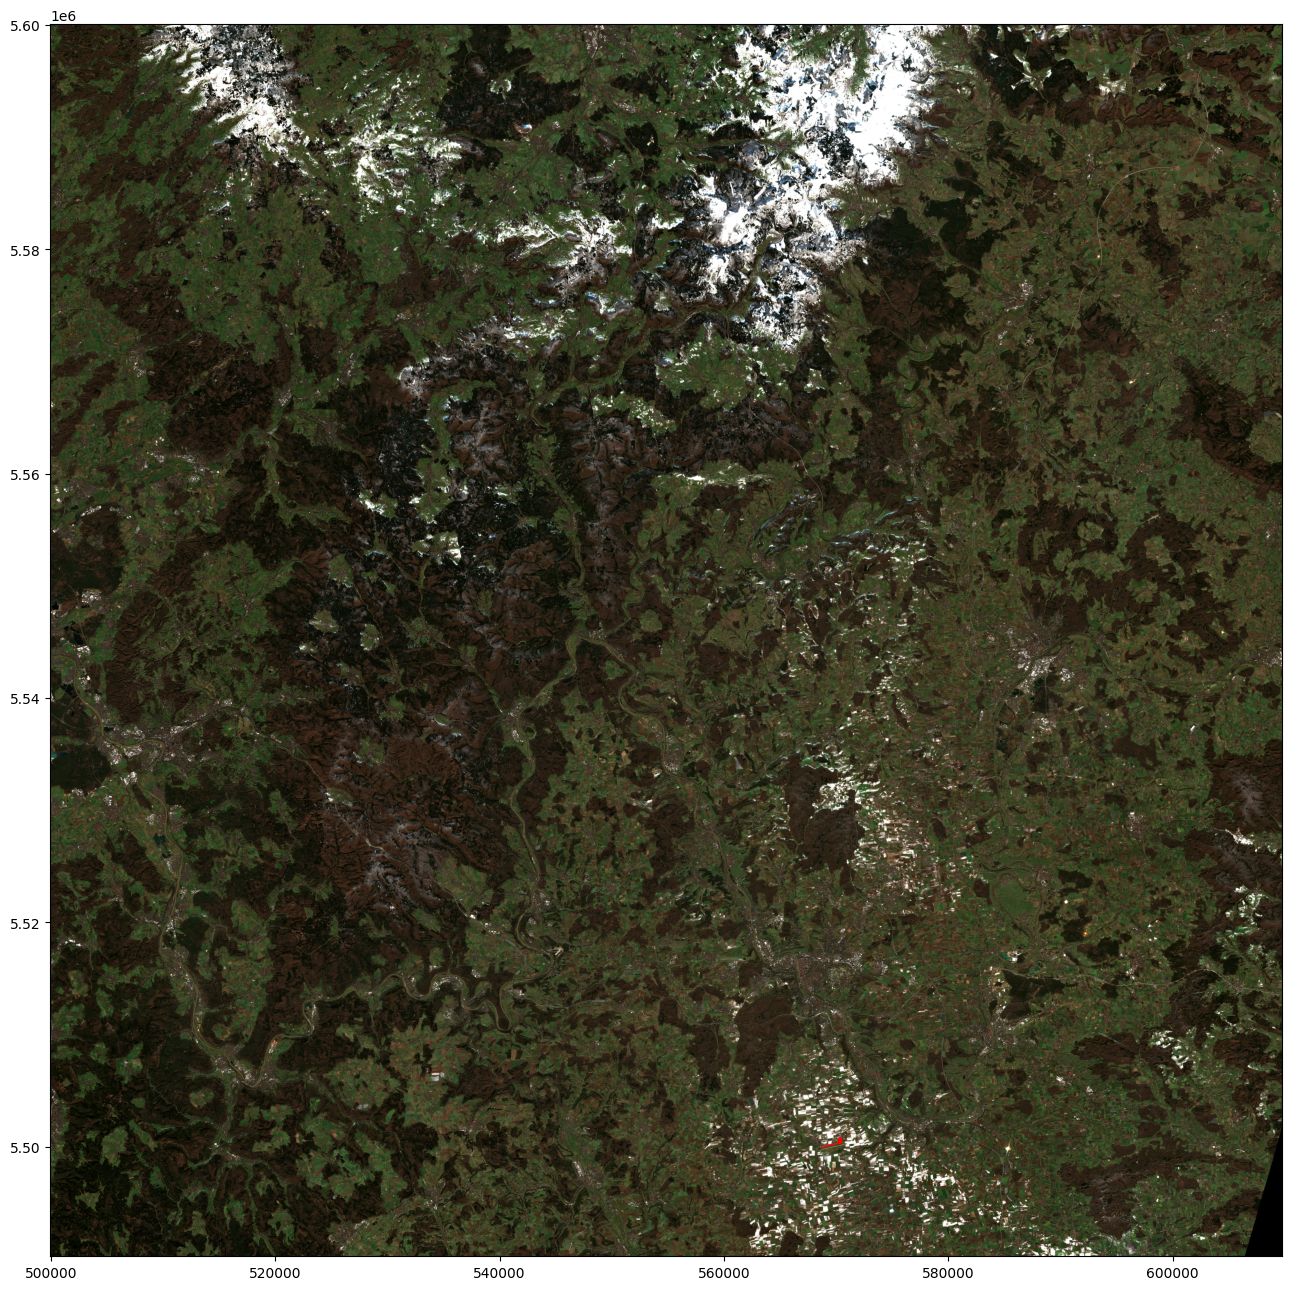

In [17]:
fig, ax = plt.subplots(figsize=(16,16))
show(image, ax=ax)
polygons_giebelstadt.plot(ax=ax, color='r')
ax.set_xlim(image_bounds[0],image_bounds[2])
ax.set_ylim(image_bounds[1],image_bounds[3])
plt.show()

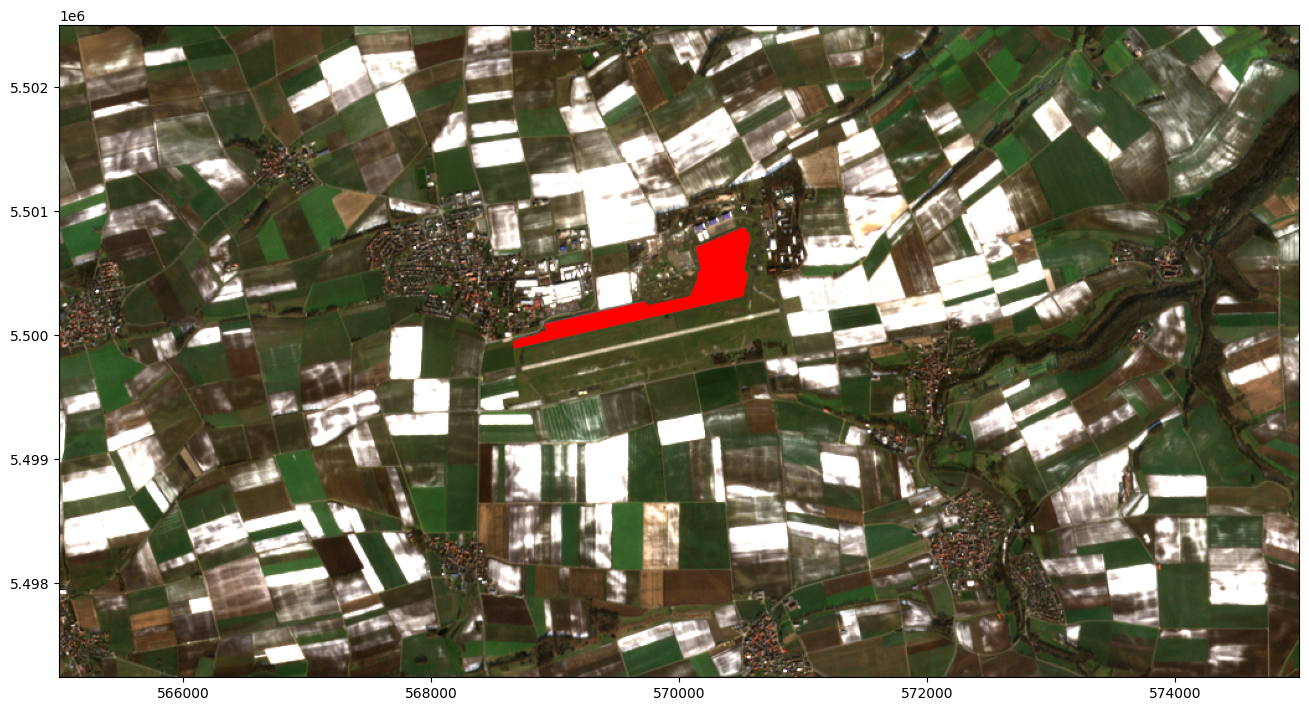

In [21]:
fig, ax = plt.subplots(figsize=(16,16))
show(image, ax=ax)
polygons_giebelstadt.plot(ax=ax, color='r')
ax.set_xlim(565000.0,575000.0)
ax.set_ylim(5497240.0,5502500.0)
plt.show()

#### The tile downloaded with sentinelsat is indeed correct

### 4. Unpack retrieved data, extract only RGB and NIR bands as well as important meta-data

In [ ]:
# extract RGB (and NIR image) from zip archive
# nested code is needed because we just unpack the needed image(s) which should increase speed
# alternatively unpack whole archive and match path to files 

# Set target filenames
target_filename = os.path.join(download_path, identifier + "_TCI_10m.jp2")

# Extract the TCI_10m image from the ZIP file
with ZipFile(os.path.join(download_path, identifier + ".zip"), mode="r") as zip:
        for source_filename in zip.namelist():
            if source_filename.endswith("_TCI_10m.jp2"):
                with zip.open(source_filename) as zf, open(target_filename, "wb") as f:
                    shutil.copyfileobj(zf, f)

### 7. Create function which takes the AoI as input and gets the unpacked RGB and NIR bands

In [10]:
def download_function(footprint, download_path):
    # connect to api
    api = SentinelAPI('taraman', 'y6HG%!6cF!86y$tK3', 'https://apihub.copernicus.eu/apihub')
    
    # query for image/product
    products = api.query(footprint,
                        date=('20220601', date(2023, 2, 11)),
                        platformname='Sentinel-2',
                        cloudcoverpercentage=(0, 30),
                        limit=1) #area_relation='IsWithin',#processinglevel="Level-2A"
                        # it is possible to convert the OrderedDict to geopandas Dataframe to work on this
    
    gdf = api.to_geodataframe(products)
    identifier = gdf.identifier[0]
    
    # download image
    api.download(gdf.uuid[0], directory_path=download_path)
    
    # Set target filenames
    target_filename = os.path.join(download_path, identifier + "_TCI_10m.jp2")

    # Extract the TCI_10m image from the ZIP file
    with ZipFile(os.path.join(download_path, identifier + ".zip"), mode="r") as zip:
            for source_filename in zip.namelist():
                if source_filename.endswith("_TCI_10m.jp2"):
                    with zip.open(source_filename) as zf, open(target_filename, "wb") as f:
                        shutil.copyfileobj(zf, f)
    # delete folder                    
    os.remove(os.path.join(download_path, identifier+'.zip'))
    return gdf, target_filename

In [11]:
# use function
download_path = r'C:\Users\Fabian\Documents\Masterarbeit_Daten\API_test2'
footprint = polygons_giebelstadt.loc[0, 'geometry'].wkt
gdf, file_name = download_function(footprint, download_path)
print(file_name)

MD5 checksumming:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

CRS.from_epsg(32632)

## The created function is used (in a modified way) in API_call_handler.py as download_sentinel2_data

1. Create bavarian dataframe with training polygons
2. Loop over all tiles 

In [22]:
from API_call_handler import download_sentinel2_data

In [3]:
tiles_grid = gpd.read_file('trn_polygons_germany_tiles.geojson')

In [4]:
borders_path = r'C:\Users\Fabian\Documents\Masterarbeit_Daten\DEU_adm\DEU_adm1.shp'
borders = gpd.read_file(borders_path)

In [5]:
# select the boundaries of the district of Wuerzburg
bavaria_borders = borders[borders.NAME_1 =='Bayern']

In [6]:
bavaria_borders 

ID_0  ISO   NAME_0  ID_1  NAME_1 TYPE_1 ENGTYPE_1  NL_NAME_1 VARNAME_1  \
1    86  DEU  Germany     2  Bayern   Land     State        NaN   Bavaria   

                                            geometry  
1  POLYGON ((10.13386 50.55000, 10.13980 50.54252...

In [18]:
polygons_bavaria = gpd.clip(tiles_grid, bavaria_borders).reset_index(drop=True)

In [19]:
polygons_bavaria.head()

osm_id   Name                              centroid_of_tile  \
0  206651601.0  32TPT  POINT (11.050613956840344 47.34058510231904)   
1  303995868.0  32TPT  POINT (11.050613956840344 47.34058510231904)   
2  303995868.0  32UPU  POINT (11.086299367013748 48.23936556859678)   
3  303995869.0  32TPT  POINT (11.050613956840344 47.34058510231904)   
4  303995869.0  32UPU  POINT (11.086299367013748 48.23936556859678)   

                                            geometry  
0  POLYGON ((11.04426 47.48953, 11.04417 47.48959...  
1  POLYGON ((10.81572 47.79383, 10.81480 47.79383...  
2  POLYGON ((10.81572 47.79383, 10.81480 47.79383...  
3  POLYGON ((10.81615 47.79385, 10.81579 47.79384...  
4  POLYGON ((10.81615 47.79385, 10.81579 47.79384...

In [35]:
# save it to geojson (needs more space on disk)
polygons_bavaria.to_file('polygons_bavaria.geojson', driver='GeoJSON')

In [36]:
polygons_bavaria = gpd.read_file('polygons_bavaria.geojson')

In [37]:
polygons_bavaria

osm_id   Name                               centroid_of_tile  \
0     206651601.0  32TPT   POINT (11.050613956840344 47.34058510231904)   
1     303995868.0  32TPT   POINT (11.050613956840344 47.34058510231904)   
2     303995868.0  32UPU   POINT (11.086299367013748 48.23936556859678)   
3     303995869.0  32TPT   POINT (11.050613956840344 47.34058510231904)   
4     303995869.0  32UPU   POINT (11.086299367013748 48.23936556859678)   
...           ...    ...                                            ...   
6667  378158816.0  33UUQ    POINT (13.01047610549643 49.14091526641636)   
6668  344215914.0  33UVP  POINT (14.391831875811269 48.256688005715716)   
6669  344215914.0  33UUP   POINT (13.045611295839896 48.24168428673839)   
6670  474082686.0  33UUP   POINT (13.045611295839896 48.24168428673839)   
6671  474082686.0  33UVP  POINT (14.391831875811269 48.256688005715716)   

     'image_path'                                           geometry  
0             NaN  POLYGON ((11.04426 47.48953, 11.04417 47.48959...  
1             NaN  POLYGON ((10.81572 47.79383, 10.81480 47.79383...  
2             NaN  POLYGON ((10.81572 47.79383, 10.81480 47.79383...  
3             NaN  POLYGON ((10.81615 47.79385, 10.81579 47.79384...  
4             NaN  POLYGON ((10.81615 47.79385, 10.81579 47.79384...  
...           ...                                                ...  
6667          NaN  POLYGON ((12.77476 48.92121, 12.77479 48.92117...  
6668          NaN  POLYGON ((13.73979 48.53547, 13.74057 48.53541...  
6669          NaN  POLYGON ((13.73979 48.53547, 13.74057 48.53541...  
6670          NaN  POLYGON ((13.73699 48.55179, 13.73825 48.55167...  
6671          NaN  POLYGON ((13.73699 48.55179, 13.73825 48.55167...  

[6672 rows x 5 columns]

In [7]:
#tiles_grid['image_path'] = tiles_grid[tiles_grid.Name == '33UVS']
tiles_grid.loc[tiles_grid["Name"] == "33UVS", "'image_path'"] = "Test"

In [9]:
tiles_grid.tail()

osm_id   Name                               centroid_of_tile  \
32948  226335168.0  33UUA  POINT (12.757434761701774 54.531811179790914)   
32949  226315509.0  33UUA  POINT (12.757434761701774 54.531811179790914)   
32950  181394364.0  33UUA  POINT (12.757434761701774 54.531811179790914)   
32951  179338993.0  33UUA  POINT (12.757434761701774 54.531811179790914)   
32952   85572355.0  33UVA  POINT (14.302079375769404 54.550588585973074)   

                                                geometry 'image_path'  
32948  POLYGON ((13.30152 54.47148, 13.30245 54.47116...          NaN  
32949  POLYGON ((13.29566 54.47219, 13.29899 54.47156...          NaN  
32950  POLYGON ((13.31349 54.54894, 13.31438 54.54878...          NaN  
32951  POLYGON ((12.01570 54.17296, 12.01600 54.17329...          NaN  
32952  POLYGON ((13.68207 54.14541, 13.68204 54.14545...          NaN

In [12]:
len(set(tiles_grid.centroid_of_tile))

64

In [11]:
len(set(polygons_bavaria.centroid_of_tile))

18

In [24]:
polygons_bavaria.centroid_of_tile[0]

'POINT (11.050613956840344 47.34058510231904)'

In [34]:
download_path = r'C:\Users\Fabian\Documents\Masterarbeit_Daten\API_test2'
from API_call_handler import download_sentinel2_data
gdf, target_folder = download_sentinel2_data(polygons_bavaria.centroid_of_tile[0], download_path)
polygons_bavaria.loc[polygons_bavaria["centroid_of_tile"] == polygons_bavaria.centroid_of_tile[0], "'image_path'"] = target_folder

AttributeError: 'GeoDataFrame' object has no attribute 'uuid'

In [14]:
n=0
for tile in set(polygons_bavaria.centroid_of_tile):
    n+=1
print(n)

18


In [37]:
len(set(tiles_grid.Name))

64

In [24]:
footprint = tiles_grid.centroid_of_tile[0]

In [36]:
len(set(tiles_grid.centroid_of_tile))

64

In [25]:
footprint

'POINT (14.357301607280887 50.95484948446869)'

In [26]:
print('Program started')
#trn_polygons_path = r'C:\Users\Fabian\OneDrive - Universität Würzburg\Uni Würzburg\Master\Masterthesis\Code\Einarbeitung\trn_polygons.geojson'
#trn_polygons = gpd.read_file(trn_polygons_path)

#germany_borders_path = r'C:\Users\Fabian\Documents\Masterarbeit_Daten\DEU_adm\DEU_adm2.shp'
#germany_borders = gpd.read_file(germany_borders_path)

#wuerzburg_borders = germany_borders[germany_borders.NAME_2 =='Bayern']

#polygons_wuerzburg= gpd.clip(trn_polygons, wuerzburg_borders)

#polygons_giebelstadt = polygons_wuerzburg[polygons_wuerzburg.name == 'Solarpark Giebelstadt'].reset_index()

download_path = r'C:\Users\Fabian\Documents\Masterarbeit_Daten\API_test2'
#footprint = polygons_giebelstadt.loc[0, 'geometry'].wkt

gdf, target_folder = download_sentinel2_data(footprint, download_path)
print('Program finished')

Program started


MD5 checksumming:   0%|          | 0.00/719M [00:00<?, ?B/s]

Program finished


In [ ]:
from collections import OrderedDict
from sentinelsat import SentinelAPI

api = SentinelAPI('user', 'password')

tiles = ['32UNA', '32UMV']

query_kwargs = {
        'platformname': 'Sentinel-2',
        'date': ('NOW-14DAYS', 'NOW'),
        'cloudcoverpercentage':('0', '30'),
        'limit':'1'}

products = OrderedDict()
for tile in tiles:
    kw = query_kwargs.copy()
    kw['tileid'] = tile
    product = api.query(**kw)
    

api.download_all(products)

### It is possible to filter for the image before download (not working yet, due to only one filter is possible)

In [11]:
footprint = polygons_giebelstadt.loc[0, 'geometry'].wkt
download_path = r'C:\Users\Fabian\Documents\Masterarbeit_Daten\API_test2'
api = SentinelAPI('taraman', 'y6HG%!6cF!86y$tK3', 'https://apihub.copernicus.eu/apihub')
# Und für nur ein product downloaden 
products = api.query(footprint,
                    date=('20220601', date(2023, 2, 11)),
                    platformname='Sentinel-2',
                    cloudcoverpercentage=(0, 30),
                    limit=1) #area_relation='IsWithin',#processinglevel="Level-2A"
                    # it is possible to convert the OrderedDict to geopandas Dataframe to work on this

gdf = api.to_geodataframe(products)
identifier = gdf.identifier[0]
#path_filter = make_path_filter("*_(TCI|B08)_10m.jp2")
api.download(gdf.uuid[0], directory_path=download_path) #, nodefilter=path_filter

Getting product info for f failed, can't download: Traceback (most recent call last):
  File "c:\Users\Fabian\OneDrive - Universität Würzburg\Uni Würzburg\Master\Masterthesis\Code\Einarbeitung\geotorch_v1\lib\site-packages\sentinelsat\sentinel.py", line 1017, in _check_scihub_response
    response.raise_for_status()
  File "c:\Users\Fabian\OneDrive - Universität Würzburg\Uni Würzburg\Master\Masterthesis\Code\Einarbeitung\geotorch_v1\lib\site-packages\requests\models.py", line 1021, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error:  for url: https://apihub.copernicus.eu/apihub/odata/v1/Products('f')?$format=json

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\Fabian\OneDrive - Universität Würzburg\Uni Würzburg\Master\Masterthesis\Code\Einarbeitung\geotorch_v1\lib\site-packages\sentinelsat\download.py", line 395, in _init_statuses
    info = self

ResultTuple(downloaded={}, retrieval_triggered={}, failed={'f': {'exception': InvalidKeyError('Invalid key (f) to access Products')}, 'e': {'exception': InvalidKeyError('Invalid key (e) to access Products')}, '4': {'exception': InvalidKeyError('Invalid key (4) to access Products')}, '8': {'exception': InvalidKeyError('Invalid key (8) to access Products')}, 'c': {'exception': InvalidKeyError('Invalid key (c) to access Products')}, '2': {'exception': InvalidKeyError('Invalid key (2) to access Products')}, '3': {'exception': InvalidKeyError('Invalid key (3) to access Products')}, '0': {'exception': InvalidKeyError('Invalid key (0) to access Products')}, '7': {'exception': InvalidKeyError('Invalid key (7) to access Products')}, 'd': {'exception': InvalidKeyError('Invalid key (d) to access Products')}, '1': {'exception': InvalidKeyError('Invalid key (1) to access Products')}, '5': {'exception': InvalidKeyError('Invalid key (5) to access Products')}, 'a': {'exception': InvalidKeyError('Inval